Thanks to: Sebastian Raschka (sraschka@wisc.edu)  

---

<a href="https://colab.research.google.com/github/andrescastro-itm/IA_ITM_2025-2/blob/main/Clase23/3-lenet5-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet-5 on MNIST

## Imports

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# From local helper files
from helper_evaluation import set_all_seeds, compute_confusion_matrix
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_mnist

## Settings and Dataset

In [9]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [10]:
print(DEVICE)

cuda:0


In [11]:
set_all_seeds(RANDOM_SEED)

In [12]:
##########################
### MNIST DATASET
##########################

resize_transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((32, 32)),
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])


train_loader, valid_loader, test_loader = get_dataloaders_mnist(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=resize_transform,
    test_transforms=resize_transform)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:01<00:00, 7437136.25it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 410355.44it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3274544.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 1910018.93it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([256, 1, 32, 32])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 5, 8, 9, 9, 4, 9, 9, 3, 9])


## Model

In [13]:
class LeNet5(torch.nn.Module):

    def __init__(self, num_classes, grayscale=False):
        super().__init__()
        
        self.grayscale = grayscale
        self.num_classes = num_classes

        if self.grayscale:
            in_channels = 1
        else:
            in_channels = 3

        self.features = torch.nn.Sequential(
            
            torch.nn.Conv2d(in_channels, 6, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, num_classes),
        )


    def forward(self, x):
        x = self.features(x)
#         print(x.shape)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

/home/andrescastro/miniconda3/envs/IA_ITM/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/015 | Batch 0000/0210 | Loss: 2.3033
Epoch: 001/015 | Batch 0100/0210 | Loss: 0.5886
Epoch: 001/015 | Batch 0200/0210 | Loss: 0.2822
Epoch: 001/015 | Train: 91.51% | Validation: 93.60%
Time elapsed: 0.56 min
Epoch: 002/015 | Batch 0000/0210 | Loss: 0.3071
Epoch: 002/015 | Batch 0100/0210 | Loss: 0.2457
Epoch: 002/015 | Batch 0200/0210 | Loss: 0.1650
Epoch: 002/015 | Train: 95.25% | Validation: 96.35%
Time elapsed: 1.04 min
Epoch: 003/015 | Batch 0000/0210 | Loss: 0.1599
Epoch: 003/015 | Batch 0100/0210 | Loss: 0.1967
Epoch: 003/015 | Batch 0200/0210 | Loss: 0.0896
Epoch: 003/015 | Train: 96.78% | Validation: 97.55%
Time elapsed: 1.51 min
Epoch: 004/015 | Batch 0000/0210 | Loss: 0.1095
Epoch: 004/015 | Batch 0100/0210 | Loss: 0.1040
Epoch: 004/015 | Batch 0200/0210 | Loss: 0.0571
Epoch: 004/015 | Train: 97.56% | Validation: 98.07%
Time elapsed: 2.00 min
Epoch: 005/015 | Batch 0000/0210 | Loss: 0.1304
Epoch: 005/015 | Batch 0100/0210 | Loss: 0.0967
Epoch: 005/015 | Batch 0200/

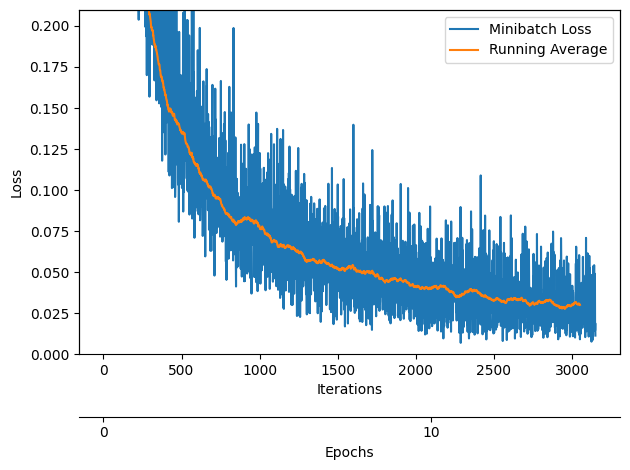

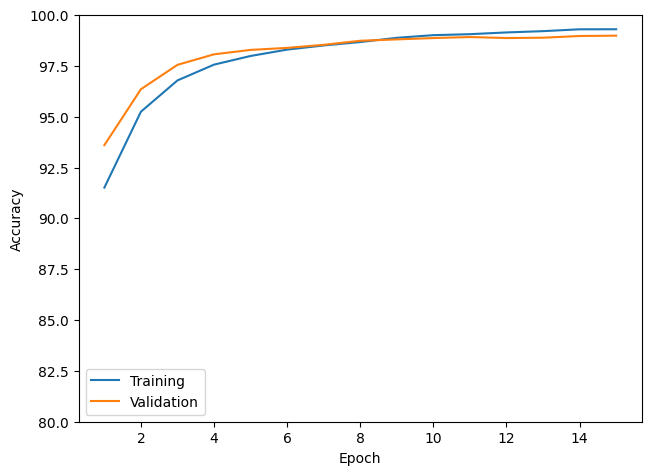

In [14]:
model = LeNet5(grayscale=True,
               num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([80, 100])
plt.show()

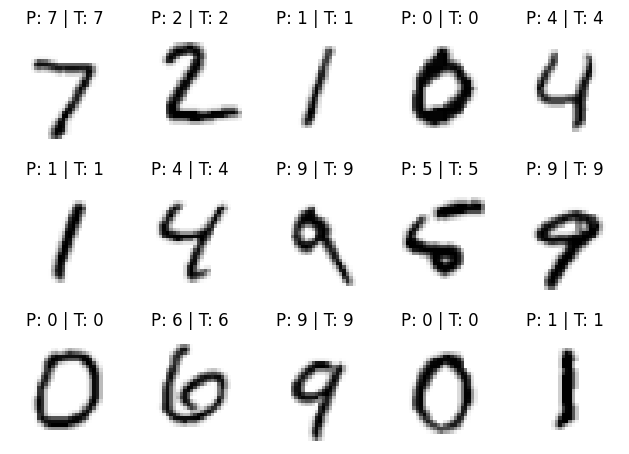

In [15]:
model.cpu()
show_examples(model=model, data_loader=test_loader)

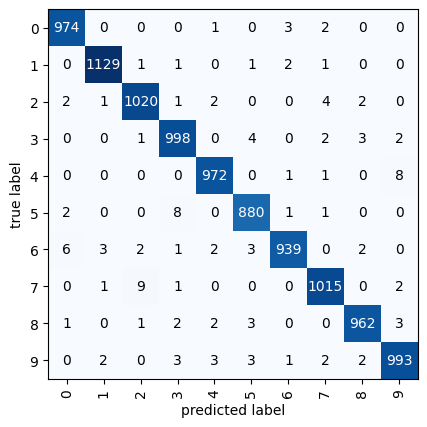

In [16]:
class_dict = {0: '0',
              1: '1',
              2: '2',
              3: '3',
              4: '4',
              5: '5',
              6: '6',
              7: '7',
              8: '8',
              9: '9'}

mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()